---
title: MNIST画像分類モデルを実装してみよう
date: today
description: このノートでは、kaggleのMNIST(手書き数字データ)を用いた画像分類を行なっていきます
categories: [kaggle, mnist, fastai]
toc: true
---

## Hello World in deep learning

このノートでは、`kaggle`の`MNIST`(手書き数字データ)を用いた画像分類を行なっていきます。深層学習には`fastai`ライブラリーを使用します。MNIST手書き数字データは、機械学習界隈のHello Worldのような、誰もが最初に通るデータセットです。ここでは複雑なモデルは用いず、三層のモデルとresnet18モデルの二つを使用します。目標は`99% accuracy`で数字を分類できるモデルをつくることです。対象読者は`kaggleの画像コンペの始め方が分からないけど興味がある人`です。MNIST画像は一見簡単そうに見えますが、初学者には取っ付きにくいものです。特に、学習に時間がかかる問題にどのように対処するのか、モデルの成果をどう測るのかといった詰まりポイントを重点的に見ていきます。逆にモデル設計の詳細(畳み込み層の動きなど)は見ていきません。

--

実装の流れは以下の通りです。

0. 必要なライブラリのインストール
1. データセットのインストール
2. トレーニングデータとテストデータの差異を確認
3. サンプルデータ上でのトレーニング
4. トレーニング結果の妥当性を確認
5. データセット全体でのトレーニング
6. まとめ
7. 参照ページ

---
以下のコードは実行環境にCUDA(GPU)が使用可能かを確認します。このノートはGPUが使えることを前提に動いています。kaggleの上でも無料でGPUが使えますが、クラウドのサービス(paperspace, google colabなど)の方がモデルの学習を早くできるのでお勧めです。

In [1]:
!nvidia-smi

Thu Oct 31 02:47:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   37C    P8    16W / 140W |      1MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 必要なライブラリのインストール

fastkaggleはfastaiとkaggle apiを合わせたライプラリーです。ここで用いられている全インポート`import *`は、fastai推奨のインポート方法です。私自身、初めは慣れずに居心地が悪い表記方法でしたが今は慣れました。jupyter notebookなどの実験(仮説と検証を繰り返す)環境では全インポートで問題ありません。

In [2]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *

### データセットのインストール

#### コンペ参加の同意とAPIキー取得

まずkaggleのコンペ参加には同意が必要になります。同意が済んだら、次はapiキーの取得です。`/root/.config/kaggle/kaggle.json`ファイルに取得したapiキーを記述します。ファイルは以下のコードで作成します。

In [3]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

#### データセットのインストール

`setup_comp`関数でデータセットを`digit-recognizer`フォルダーにインストールします。ここでエラーが出た場合は、もう一度apiキーが設定されているか、競技の同意が済んでいるかを見てみます。よくあるエラー原因は競技名のスペルミスです。

In [4]:
comp = "digit-recognizer"

path = setup_comp(comp)
path.ls()

100%|██████████| 15.3M/15.3M [00:00<00:00, 74.5MB/s]


(#3) [Path('digit-recognizer/sample_submission.csv'),Path('digit-recognizer/test.csv'),Path('digit-recognizer/train.csv')]

トレーニングデータは42000、テストデータは28000サンプルあることがわかります。

In [5]:
trn_df = pd.read_csv(path/"train.csv")
tst_df = pd.read_csv(path/"test.csv")
smp_df = pd.read_csv(path/"sample_submission.csv")

trn_df.shape, tst_df.shape, smp_df.shape

((42000, 785), (28000, 784), (28000, 2))

#### トレーニングデータをざっくり見てみる

最初の行(label行)にはデータのラベルが、その他の行(pixel0 - 783行)にはピクセルデータが格納されていることがわかります。このデータは色(color channel)の無い白黒画像であることが推測できます。

In [6]:
trn_df.head(n=3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ラベルは0から9の10ラベルです。それぞれ約4000個と、おおよそ均等に配分されたデータセットであることが分かります。

In [7]:
trn_df["label"].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

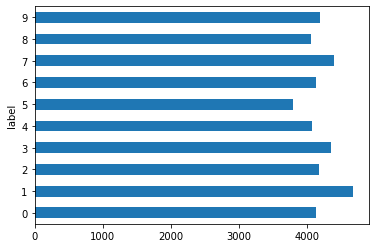

In [8]:
trn_df.groupby("label").size().plot.barh();

ラベルとピクセルデータ(画像)が対応していることを確認します。

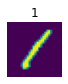

In [9]:
idx = 0
label, img_val = trn_df.iloc[idx, 0], trn_df.iloc[idx, 1:].values

show_image(img_val.reshape((28, 28)), title=label);

#### ピクセルデータを画像データに変換

trainとtestフォルダそれぞれに画像データを保存します。

In [10]:
!mkdir {path}/train
!mkdir {path}/test
path.ls()

(#5) [Path('digit-recognizer/train'),Path('digit-recognizer/sample_submission.csv'),Path('digit-recognizer/test.csv'),Path('digit-recognizer/train.csv'),Path('digit-recognizer/test')]

In [11]:
def save_img(img, f_path):
    img = img.reshape((28, 28))
    img = Image.fromarray(img.astype("uint8"))
    img.save(f_path)

In [12]:
for idx, row in trn_df.iterrows():
    label, img = row[0], row[1:]

    f_path = f"{path}/train/{label}_{idx}.jpg"
    save_img(img.values, f_path)

In [13]:
(path/"train").ls()

(#42000) [Path('digit-recognizer/train/7_19624.jpg'),Path('digit-recognizer/train/2_40612.jpg'),Path('digit-recognizer/train/3_32852.jpg'),Path('digit-recognizer/train/1_13520.jpg'),Path('digit-recognizer/train/9_29764.jpg'),Path('digit-recognizer/train/6_16260.jpg'),Path('digit-recognizer/train/9_18518.jpg'),Path('digit-recognizer/train/0_13218.jpg'),Path('digit-recognizer/train/5_32574.jpg'),Path('digit-recognizer/train/7_20089.jpg')...]

In [14]:
for idx, img in tst_df.iterrows():
    f_path = f"{path}/test/{idx}.jpg"
    save_img(img.values, f_path)

In [15]:
(path/"test").ls()

(#28000) [Path('digit-recognizer/test/13420.jpg'),Path('digit-recognizer/test/22873.jpg'),Path('digit-recognizer/test/6022.jpg'),Path('digit-recognizer/test/13644.jpg'),Path('digit-recognizer/test/1332.jpg'),Path('digit-recognizer/test/3737.jpg'),Path('digit-recognizer/test/617.jpg'),Path('digit-recognizer/test/10239.jpg'),Path('digit-recognizer/test/14546.jpg'),Path('digit-recognizer/test/4200.jpg')...]

###  トレーニングデータとテストデータの差異を確認

まず分類モデルを作る前に、二つのデータセット(トレーニング・テスト)に違いがないこと確認します。例えばトレーニングセットには0から9までの数字画像が、テストセットには10から19までの数字といった全く違う種類のデータが入っているかもしれません。**二つのデータセットに差異がないことは、この後の分類モデルを作る際の前提になります。** 二つのデータセットの差異確認は深層学習モデルを用いて行います。ここでのラベルは`train`/`test`となり、モデルは画像がどちらのデータセットに属しているのかを予測します。全データセット70000に対して、トレーニングは42000、テストは28000あります。もし、モデルが`0.6 accuracy`(42000/70000=0.6)から離れた値を出す場合、二つのデータセットは異なる種類のものであると推測できます。

In [16]:
def label_func(f_path): return f_path.parent.name

label_func((path/"train").ls()[0]), label_func((path/"test").ls()[0])

('train', 'test')

In [17]:
def get_db(size=28):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=label_func,
        splitter=RandomSplitter(),
        item_tfms=Resize(size),
        batch_tfms=[*aug_transforms(do_flip=False, min_scale=0.8), Normalize.from_stats(*imagenet_stats)]
    )

mnist = get_db()

学習用のデータセットを用意する場合、全トレーニングデータを使う必要はありません。**アイデアの有効性を試す実験段階では、開発サイクルを高速で回すためにも少ないサンプル数を使用します。** ここではランダムに、トレーニングデータセットから10%のデータを取得しています。どのようにサンプルデータを用意するのかは様々な手法がありますが、今回のような画像分類モデルでは、各ラベルのサンプル数が300ほどあれば実験用途として十分な気がします。以下の`dls.show_batch`による画像の表示は、ざっとデータを理解するのに役立ちます。トレーニングの前段階で、トレーニングデータ(画像+対応するラベル)を確認するのは必須ステップです。

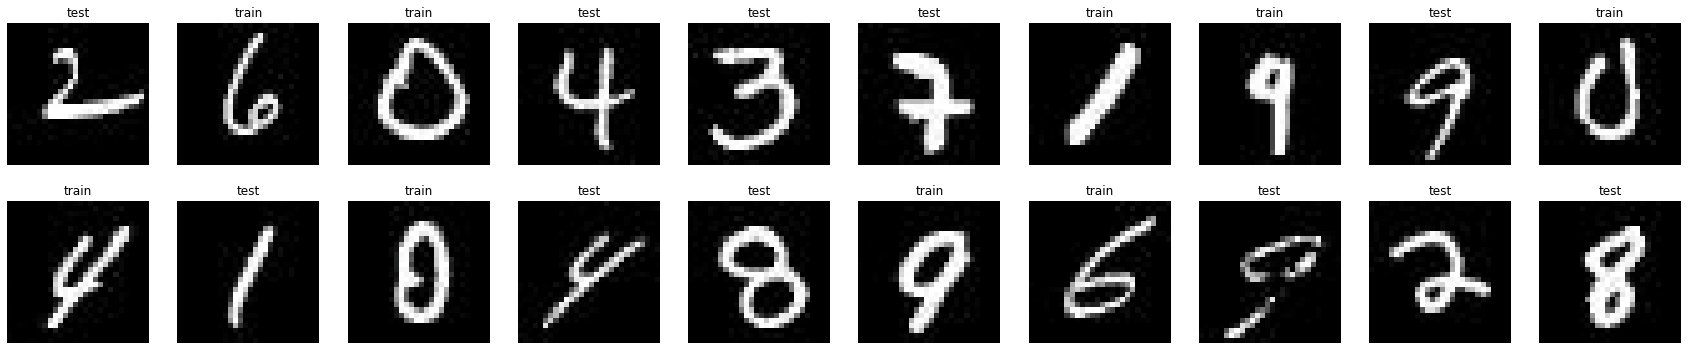

In [18]:
def get_dls(db, path, sample=1, bs=256):
    # https://knowing.net/posts/2022/05/fastai-dataloaders/
    dls = db.dataloaders(path, bs=bs)
    selected_items = random.sample(dls.train_ds.items,  int(len(dls.train_ds.items)*sample))
    dls.train = dls.test_dl(selected_items, with_labels=True)
    return dls

dls = get_dls(mnist, path, sample=0.1)
dls.show_batch(max_n=20, nrows=2, ncols=10)

モデルの設計は入力/出力を中心に行います。fastaiはPytorchの上に作られたライブラリーなので、画像型は`(N, C, H, W)`、つまり`(バッチ数, カラーチャンネル, 縦, 横)`としてモデルに入力されます。モデルの出力はデータセットのラベル数`dls.c`によって決まります。ここではモデルは画像がトレーニング・テストセットのどちらに属しているのかを予測します。

In [19]:
def get_model():
    return nn.Sequential(
        nn.Conv2d(3, 1, 1),
        # nn.Upsample(size=(28, 28)), # Needs Upsample layer if you'll use learn.tta() later
        nn.Flatten(1),
        nn.Dropout(0.1),
        nn.Linear(28*28, 100),
        nn.BatchNorm1d(100),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(100, dls.c)
    )

get_model()

Sequential(
  (0): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=784, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.2, inplace=False)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=2, bias=True)
)

学習に必要なデータセットの用意・モデルの設計が済んだら、いよいよトレーニングの開始です。`learn.lr_find`関数で学習率を求めたらトレーニングサイクルを回します。

SuggestedLRs(valley=0.015848932787775993)

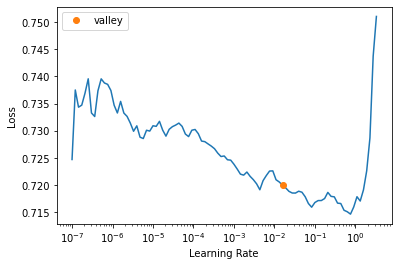

In [20]:
learn = Learner(dls, get_model(), loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()
learn.lr_find()

結果はおおよそ`59% accuracy`で、画像がどちらのデータセットに属しているのかを予測しています。二つのデータセットに差異はなさそうです。

In [21]:
learn.fit_one_cycle(4, lr_max=slice(3e-3, 3e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.710549,0.795406,0.597000,00:13
1,0.700336,0.704644,0.568500,00:12
2,0.688758,0.678533,0.596929,00:12
3,0.674994,0.681112,0.586357,00:11


### サンプルデータ上でのトレーニング

では、本題の画像分類モデルのトレーニングに移っていきます。サンプルデータの用意・画像の表示を行い、モデルの学習率を求めます。先のデータと同じ画像データを用いますが、今回は対応するラベルが異なります。ここでは、モデルは画像が0から9までのどの数字であるかを予測します。

In [22]:
def label_func(f_path): return f_path.name.split("_")[0]

(path/"train").ls()[0], label_func((path/"train").ls()[0])

(Path('digit-recognizer/train/7_19624.jpg'), '7')

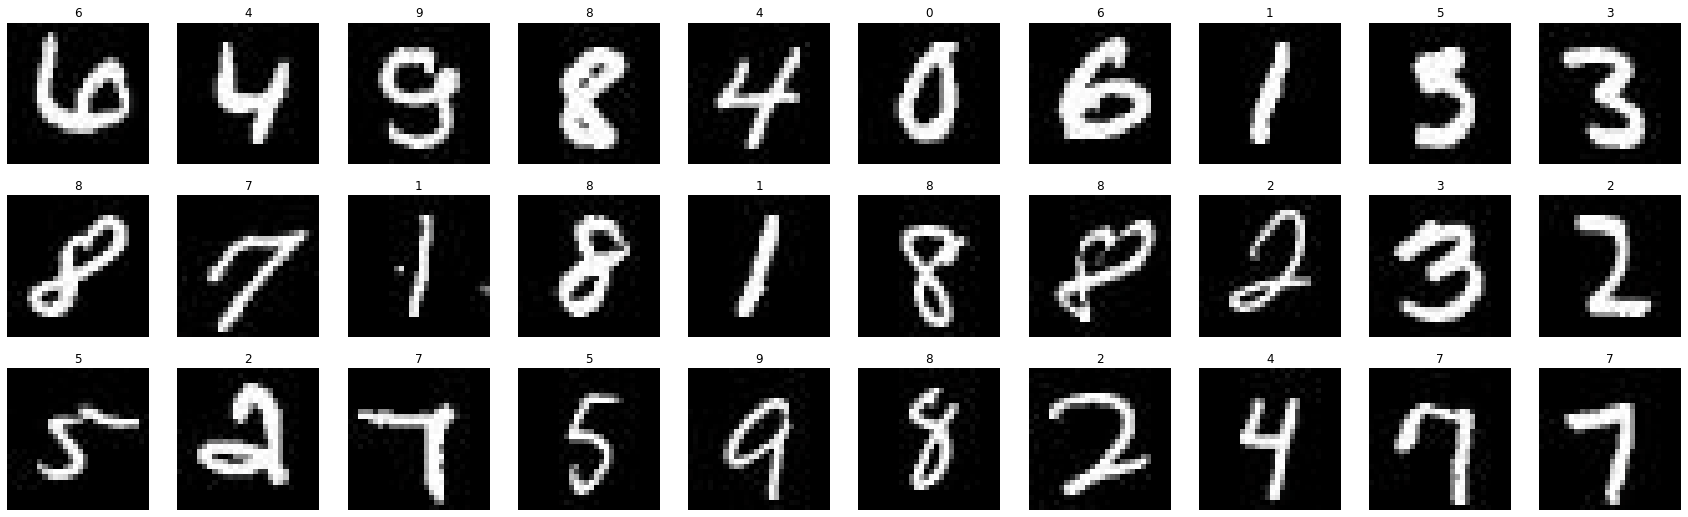

In [23]:
mnist = get_db()
dls = get_dls(mnist, path/"train", sample=0.1)
dls.show_batch(max_n=30, nrows=3, ncols=10)

SuggestedLRs(valley=0.0014454397605732083)

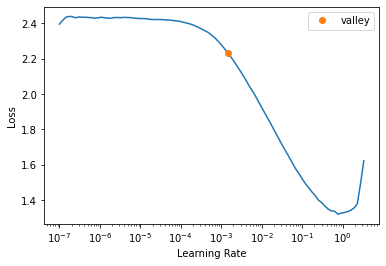

In [24]:
learn = Learner(dls, get_model(), loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()
learn.lr_find()

おおよそ`0.91 accuracy`の精度のモデルを、10%のトレーニングデータで作りました。この時点でトレーニングデータを増やし、モデルの精度を高めようとする方法がありますが、これは間違いです。**トレーニングデータ量を増やすことは過学習を防ぐのに有効ですが、学習不足には違う対処が求められます。** まずは他のモデルの精度と比較して、学習済みのモデルが過学習か学習不足かを見ていきます。ここではresnet18を比較モデルとします。

In [25]:
learn.fit_one_cycle(6, lr_max=slice(3e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.595407,1.169721,0.635357,00:07
1,1.004385,0.500168,0.851667,00:03
2,0.707560,0.360822,0.888214,00:03
3,0.542243,0.318499,0.904405,00:03
4,0.434244,0.306300,0.910000,00:03
5,0.363178,0.299947,0.909881,00:03


SuggestedLRs(valley=0.0010000000474974513)

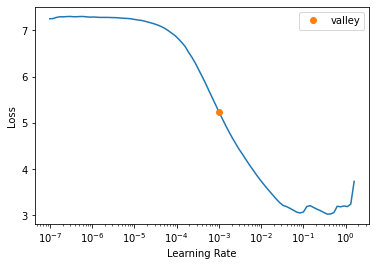

In [26]:
learn = Learner(dls, resnet18(), loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()
learn.lr_find()

先のモデルと比較して、resnet18はより精度の高いモデルであることが分かります。モデルの複雑性もそうですが、転移学習によって精度が高まったとも言えます。モデル精度の比較結果から、先のモデルは学習不足であったことが分かります。一般的に、過学習になる前段階で注意するポイントは学習不足です。学習不足にはより複雑なモデルが有効です。トレーニングサイクルを増やす、学習率を少し上げるなども学習不足に効果的です。よくある間違いは、過学習になる前(学習不足段階)に過学習を防ぐ手法(データ量を増やす、データ拡張、regularizationなど)を用いることです。**過学習への対処は、過学習が起きた後に行います。起きる前、予防的には行いません。**

In [27]:
learn.fine_tune(6, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.481695,1.180103,0.615119,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.227101,0.339515,0.909167,00:03
1,0.168335,0.627921,0.838571,00:04
2,0.143743,0.432962,0.900833,00:03
3,0.120995,0.268689,0.937381,00:03
4,0.091097,0.148554,0.959881,00:03
5,0.066370,0.122915,0.967143,00:03


トレーニング・検証データそれぞれの損失を見てきます。トレーニングデータの損失はスムーズな減少が見られますが、検証データの損失はスムーズではない形で推移しています。一つ考えられる原因は、重みの更新が急であることです。スムーズな損失の推移には、いくつかの正則化テクニックが効果的です。`weight decay`を後のトレーニングで試していきたいと思います。

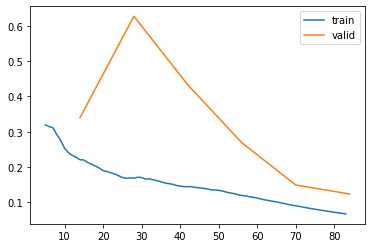

In [28]:
learn.recorder.plot_loss()

### トレーニング結果の妥当性を確認

学習済みのモデルが数字を正しく予測しているか、検証画像(学習していないデータ)を用いて見ていきます。おおよそ、モデルは正しく手書き画像を分類できていることが分かります。

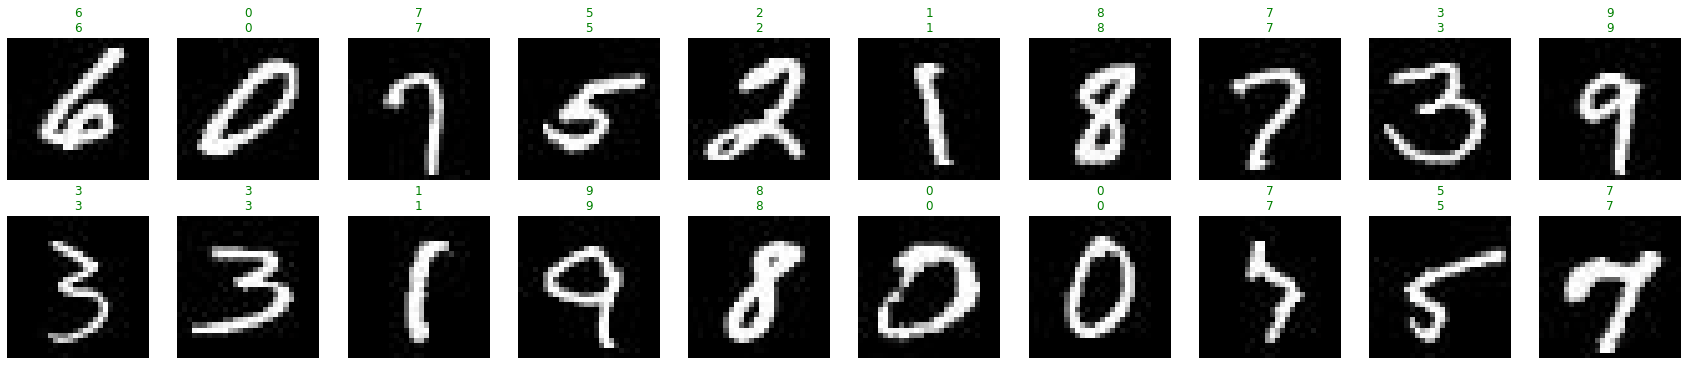

In [29]:
learn.show_results(max_n=20, nrows=2, ncols=10)

逆に、モデルがどの数字画像を正しく予測できていないかを見ていきます。2と7、4と9の数字ペアの分類が、モデルの最も不得意とする画像であることが分かります。

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=15)

[('2', '7', 20), ('4', '9', 19)]

ここではモデルが実際に間違えた予測をしている画像を見ていきます。ざっくりと見た時、モデルが間違えた画像は人間が見ても間違えそうな、紛らわしい数字であることが見て取れます。この紛らわしいラベルへの対処方としては、`label smoothing`の導入があります。

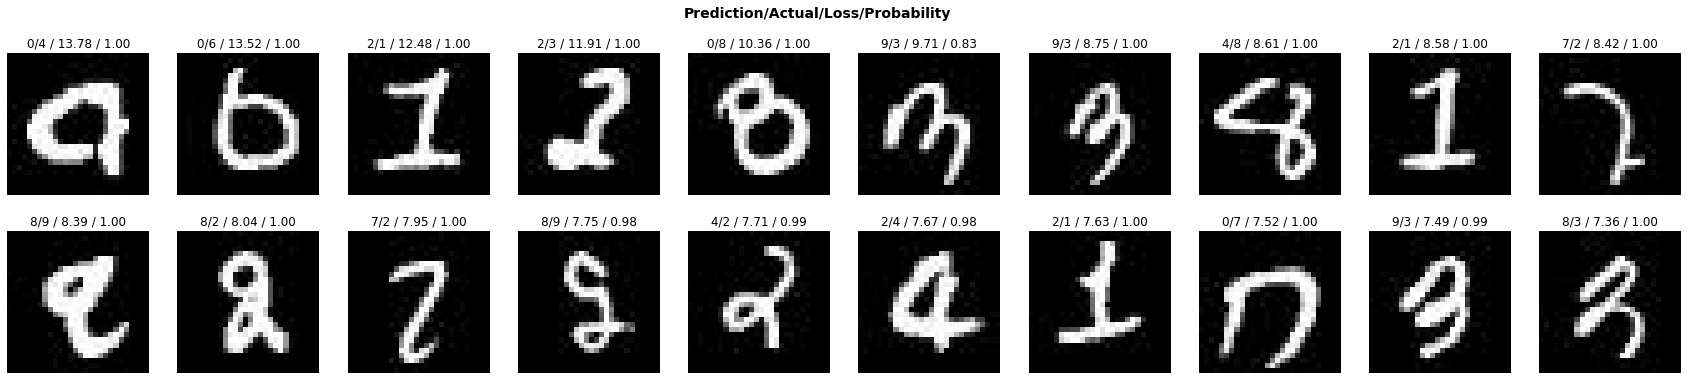

In [31]:
interp.plot_top_losses(k=20, nrows=2, ncols=10)

### データセット全体でのトレーニング

では先のトレーニング結果を踏まえて、再度トレーニングをしていきます。モデル・データセットは同様に、label smoothing・weight decayを新たに使用します。label smoothing関数はラベルのノイズを抑え損失を滑らかにしますが、より多くのトレーニングサイクルを必要とします。先のトレーニングとの相違点は、accuracyの精度は上がっている一方、lossが以前より高い値であることです。ここでの注意点は、**accuracyの精度を見ること・lossは参考程度に見ること**です。lossはモデルがトレーニングしやすいように設計された関数の出力です。見るべき大事なポイント(モデルの精度)はaccuracyです。

In [46]:
learn = Learner(dls, resnet18(), loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy).to_fp16()
learn.fine_tune(9, 2e-3, wd=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,3.378253,2.647140,0.526190,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.336900,1.490081,0.937024,00:03
1,1.207181,1.428404,0.939048,00:03
2,1.151014,1.397945,0.923333,00:03
3,1.131866,1.395567,0.904762,00:03
4,1.111709,1.244161,0.941310,00:03
5,1.094381,1.210672,0.945476,00:03
6,1.079392,1.151900,0.958809,00:03
7,1.064843,1.112762,0.970357,00:03
8,1.053271,1.109932,0.971310,00:03


モデルの精度・loss推移の滑らかさともに向上しています。

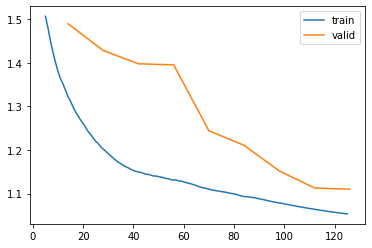

In [48]:
learn.recorder.plot_loss()

#### 全データでトレーニング
今度は全トレーニングデータを用いて学習サイクルを回します。ここでのポイントは、ぼーっと学習の進行を見ない・ノートブックから離れることです。

SuggestedLRs(valley=0.0006918309954926372)

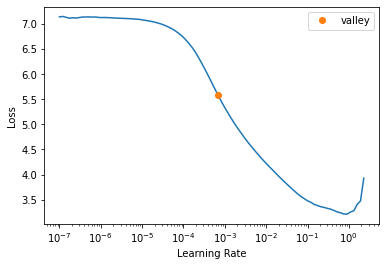

In [50]:
dls = get_dls(mnist, path/"train", sample=1) # Use all training image samples
learn = Learner(dls, resnet18(), loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy).to_fp16()
learn.lr_find()

In [51]:
learn.fine_tune(15, 1e-3, wd=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,1.352898,1.110789,0.974286,00:32


epoch,train_loss,valid_loss,accuracy,time
0,1.050016,1.066425,0.983810,00:33
1,1.039457,1.074759,0.982262,00:33
2,1.050062,1.090605,0.977381,00:33
3,1.048530,1.073222,0.982857,00:35
4,1.041486,1.075171,0.981310,00:34
5,1.038663,1.071839,0.983929,00:35
6,1.031112,1.061485,0.986905,00:36
7,1.026435,1.066055,0.985714,00:34
8,1.025973,1.065412,0.985833,00:34
9,1.020517,1.052722,0.990000,00:35


#### テストデータでモデルの精度を評価

では、学習済みモデルの精度をテストデータで評価していきます。まずはテストファイルを名前順にソートし、テスト画像(ラベルは含まれていない)を表示します。`learn.dls.test_dl`は、トレーニング画像と同じ下処理を、テスト画像に行う便利な関数です。

In [52]:
# https://stackoverflow.com/questions/33159106/sort-filenames-in-directory-in-ascending-order
ordered_tst_files = get_image_files(path/"test").sorted(key=lambda f:  int(re.findall("(\d+).jpg$", f.name)[0]))
ordered_tst_files[:10]

(#10) [Path('digit-recognizer/test/0.jpg'),Path('digit-recognizer/test/1.jpg'),Path('digit-recognizer/test/2.jpg'),Path('digit-recognizer/test/3.jpg'),Path('digit-recognizer/test/4.jpg'),Path('digit-recognizer/test/5.jpg'),Path('digit-recognizer/test/6.jpg'),Path('digit-recognizer/test/7.jpg'),Path('digit-recognizer/test/8.jpg'),Path('digit-recognizer/test/9.jpg')]

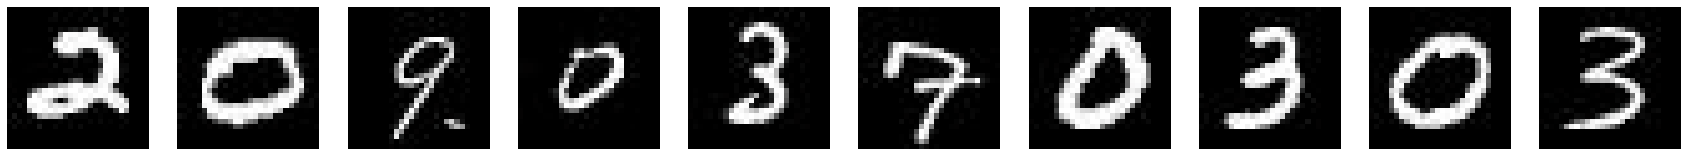

In [53]:
test_dl = learn.dls.test_dl(ordered_tst_files)
test_dl.show_batch(max_n=10, nrows=1, ncols=10)

学習済みモデルにテスト画像を予測(分類)させます。

In [55]:
preds = learn.get_preds(dl=test_dl, with_decoded=True)
preds

(tensor([[7.9680e-05, 5.4073e-05, 8.9991e-01,  ..., 9.6678e-05, 9.9019e-05,
          1.0097e-04],
         [8.9885e-01, 7.8046e-05, 1.3502e-04,  ..., 1.0204e-04, 1.0433e-04,
          9.8660e-05],
         [7.4821e-05, 1.0368e-04, 1.0127e-04,  ..., 1.0342e-04, 1.0242e-04,
          1.0302e-04],
         ...,
         [6.9998e-05, 5.2941e-05, 2.7252e-05,  ..., 1.0606e-04, 1.0679e-04,
          9.8137e-05],
         [9.9981e-05, 8.6992e-05, 9.6574e-05,  ..., 1.0136e-04, 1.0376e-04,
          9.7474e-05],
         [5.9522e-05, 4.7224e-05, 9.0107e-01,  ..., 8.9877e-05, 9.8856e-05,
          9.8278e-05]]),
 None,
 tensor([2, 0, 9,  ..., 3, 9, 2]))

予測した数字が妥当かどうか、画像と一緒に見比べてみます。モデルはテスト画像の数字を分類できていそうです。

tensor([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])


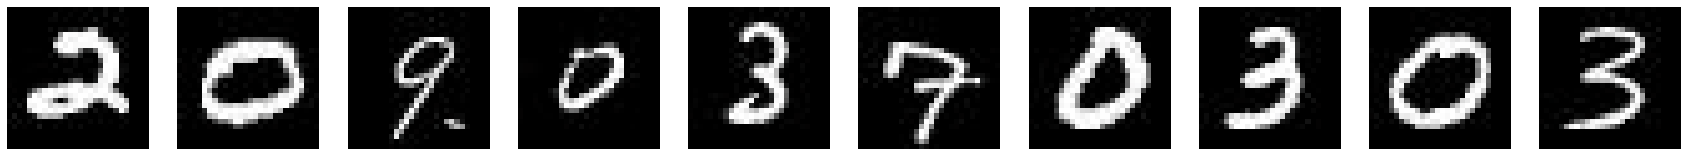

In [56]:
print(preds[2][:10])
test_dl.show_batch(max_n=10, nrows=1, ncols=10)

予測した値をcsvファイルに保存し、kaggleに提出します。

In [57]:
smp_df["Label"] = preds[2].apply_(lambda x: int(learn.dls.vocab[x]))
smp_df.to_csv(path/"submission.csv", index=False)
!head {path}/submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


In [58]:
from kaggle import api
api.competition_submit_cli(path/"submission.csv", "first model", comp)

100%|██████████| 208k/208k [00:00<00:00, 657kB/s]


Successfully submitted to Digit Recognizer

最後にインストールしたzipファイルと画像ファイルを削除します。

In [59]:
!rm -rf {path}
!rm -rf digit-recognizer.zip

### まとめ

![kaggle の結果](result.png "kaggleの結果")

目標値`99% accuracy`を達成することができました。今回のポイント三点をまとめていきます。

* 少ないサンプル数を使用して、高速な開発サイクルを回す。
→ 全サンプルを使用するのは、一番最後に。
* 過学習の対処は過学習が起きた後に行う。
→ 予防的には行わない。先に注意するのは学習不足とその対処。
* モデル精度の評価はメトリックを見る。
→ 損失の推移は参考程度に。

もしも読者がこのノートを役に立ったと思ったら、リアクションボタンを押してもらえると幸いです。質問や間違いがあれば、以下コメント欄に書き込んでください。

### 参照ページ
* [kaggle公式競技ページ](https://www.kaggle.com/competitions/digit-recognizer)
* [mnistデータセットのwiki](https://en.wikipedia.org/wiki/MNIST_database#:~:text=The%20MNIST%20database%20)
* [fastaiのクリエイター(Jeremy Howardさん)のノートブック](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1/notebook)
* [他の競技参加者(Jacopo Repossiさん)のノートブック](https://www.kaggle.com/code/jacoporepossi/fastai-datablock-augmentation-ensembling-tta)